In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from model import lorenz63

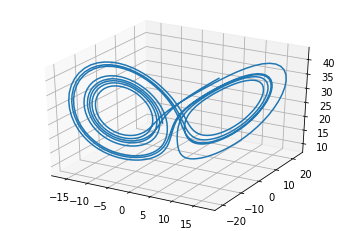

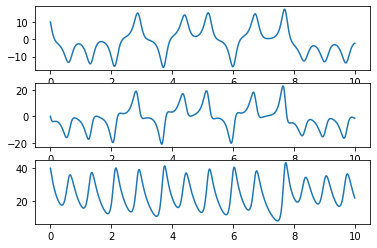

In [2]:
ts = np.arange(0, 10, 0.01)
result = lorenz63([10, 0, 40], ts)
x, y, z = result.y

fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(x, y, z)

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, x)
axs[1].plot(ts, y)
axs[2].plot(ts, z)

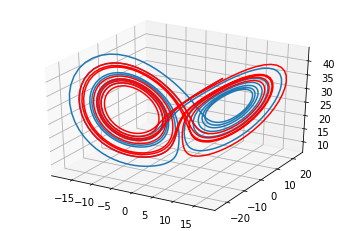

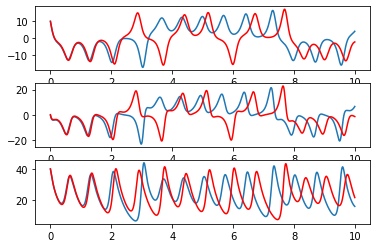

In [3]:
ts = np.arange(0, 10, 0.01)
result = lorenz63([10.1, -0.5, 40.1], ts)
x2, y2, z2 = result.y

fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(x2, y2, z2)
ax1.plot(x, y, z, color='red')

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, x2)
axs[1].plot(ts, y2)
axs[2].plot(ts, z2)
axs[0].plot(ts, x, color='red')
axs[1].plot(ts, y, color='red')
axs[2].plot(ts, z, color='red')

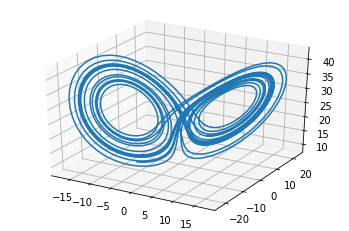

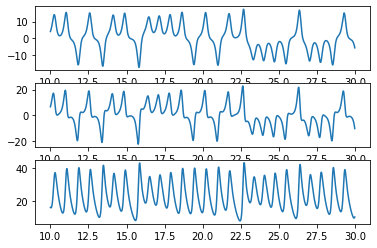

In [67]:
## X = [[x0, x1, x2, ....],
##      [y0, y1, y2, ....],
##      [z0, z1, z2, ....]]


# spin up
spinup_time = 10
dt = 0.01
X0 = np.array([[10.1], [-0.5], [40.1]])
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

# save nature run
time = 20
dt = 0.01
ts = np.arange(spinup_time, spinup_time+time, dt)
X0 = X_spn[:,[-1]]
result = lorenz63(X0.ravel(), ts)
X_nature = result.y

# plot nature run
fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(X_nature[0,:], X_nature[1,:], X_nature[2,:])

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, X_nature[0,:])
axs[1].plot(ts, X_nature[1,:])
axs[2].plot(ts, X_nature[2,:])

In [68]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        Default is 42.
    """
    if random_state is None:
        random_state = 42
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

In [69]:
obs_mean = 0
obs_var = 1
obs_timeintv = 2
cycle_num = int(time / obs_timeintv)

X_obs_err = np.zeros((3, cycle_num))
for irow, random_state in enumerate([40, 41, 42]):
    X_obs_err[irow,:] = gen_random_normal(obs_mean, obs_var, cycle_num, random_state)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

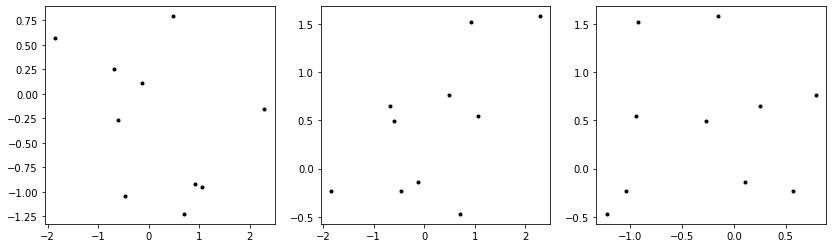

In [70]:
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

In [71]:
# spin up and get initial condition for experiments
X0 = np.array([[10.1], [-0.5], [40.1]]) + gen_random_normal(0, 0.1, size=1)
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

X_ini = X_spn[:,[-1]]
X_ini

array([[ 2.02552249],
       [ 3.39464921],
       [16.88968713]])

In [72]:
def assimilation_cycle(x0, model, dt, cycle_len, ncycle, scheme, **kwargs):
    result = np.zeros((x0.size, int(cycle_len*ncycle/dt)))
    xb = x0
    t_start = 0
    ts = np.arange(t_start, cycle_len, dt)
    for nc in range(ncycle):
        # calculate analysis field, then forecast
        xa = scheme(xb, **kwargs)
        x = model(xa.ravel(), ts).y
        result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
        # for next cycle
        xb = x[:,-1]
        t_start = int(ts[-1] + dt)
        ts = np.arange(t_start, t_start+cycle_len, dt)
        
    return result

In [80]:
def temp_scheme(xb):
    return xb
    
temp_assim = assimilation_cycle(X_ini, lorenz63, dt, 2, 10, temp_scheme)
temp_assim

array([[ 2.02552249,  2.16543385,  2.31229638, ...,  4.86054592,
         5.2136109 ,  5.59501134],
       [ 3.39464921,  3.59641957,  3.82035992, ...,  8.25399477,
         8.88429623,  9.55503828],
       [16.88968713, 16.51751706, 16.16477787, ..., 13.75323764,
        13.81719791, 13.94525591]])

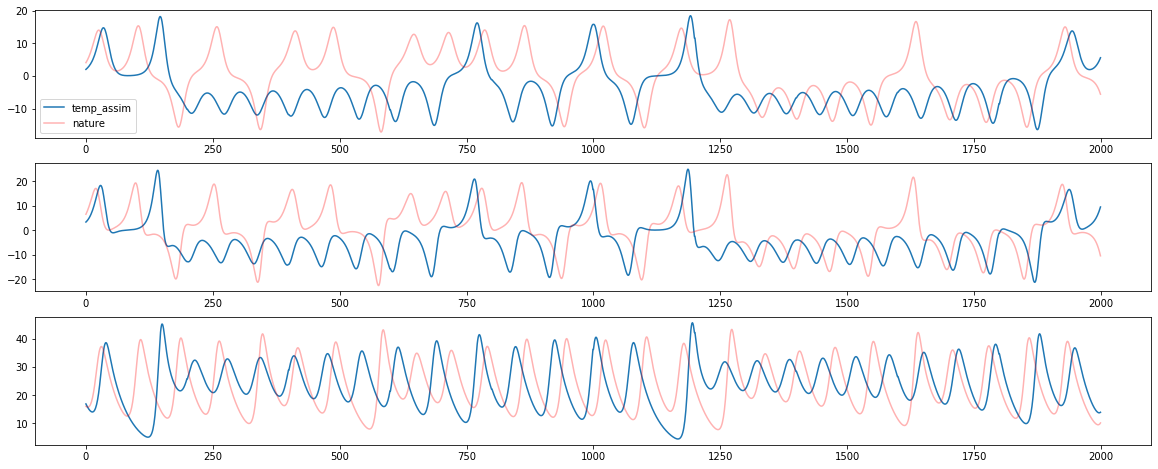

In [85]:
fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
axs[0].plot(temp_assim[0,:], label='temp_assim')
axs[1].plot(temp_assim[1,:])
axs[2].plot(temp_assim[2,:])
axs[0].plot(X_nature[0,:], color='red', alpha=0.3, label='nature')
axs[1].plot(X_nature[1,:], color='red', alpha=0.3)
axs[2].plot(X_nature[2,:], color='red', alpha=0.3)
axs[0].legend()

In [ ]:
def nmc(t1, t2, ndim, obs_error, alpha, model, da, maxiter=5):
    """
    Using NMC method to construct background error covariance matrix.
    Parrish and Derber 1992, MWR
    """
    Pb = np.zeros((ndim,ndim))
    np.fill_diagonal(Pb, obs_error)
    
    Pb_history = np.zeros((maxiter, Pb.size))
    
    for idx in range(maxiter):
        pass